# Version of the graph notebook that loads a GFA file from my laptop

...instead of the massive one on the cluster that has sequences included.

Used for manual testing. There's probably a less clunky way to handle this.

In [1]:
%run "Header.ipynb"

In [2]:
import networkx as nx
import matplotlib
from matplotlib import pyplot
from statistics import median

# We ignore directionality for right now.
graph = nx.Graph()

with open("/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201202_graph_noseq.gfa", "r") as gfafile:
    for line in gfafile:
        # Parse sequences. We convert these to "nodes" in the networkx representation of the graph,
        # but they are really edges in the repeat graph produced by metaFlye.
        if line[0] == "S":
            parts = line.strip().split("\t")
            # Strip off the "edge_" name prefix -- turn "edge_123" into "123", for example
            node_name = parts[1]
            node_cov = None
            
            # Parse GFA tags
            extra_data = parts[3:]
            for tag in extra_data:
                if tag.startswith("LN:i:"):
                    node_len = int(tag[5:])
                elif tag.startswith("dp:i:"):
                    if node_cov is None:
                        node_cov = int(tag[5:])
                    else:
                        raise ValueError("Duplicate coverage for node {}".format(node_name))
                        
            if node_cov is None:
                raise ValueError("No coverage tag given for node {}".format(node_name))
                
            graph.add_node(node_name, length=node_len, cov=node_cov)
            
        # Parse links between sequences.
        # Each link line looks something like:
        #
        # L    edge_74133    -    edge_71431    -    0M
        #
        # (where the whitespace gaps are each a single tab character)
        elif line[0] == "L":
            parts = line.strip().split("\t")
            # Again, the [5:] slices are needed to remove the "edge_" prefix.
            src = parts[1]
            snk = parts[3]
            # As mentioned, we ignore directionality for this specific application. So, e.g.:
            # A+ -> B+
            # A+ -> B-
            # A- -> B+
            # A- -> B-
            # ... would all get treated as the same edge. "Duplicate" edges are implicitly ignored by networkx.
            graph.add_edge(src, snk)

print("Graph contains {} edges (represented as GFA segments).".format(graph.number_of_nodes()))
print("Graph contains {} links between edges (ignoring directionality for now).".format(graph.number_of_edges()))
print("Graph contains {} connected components.".format(nx.number_connected_components(graph)))

Graph contains 78793 edges (represented as GFA segments).
Graph contains 4299697 links between edges (ignoring directionality for now).
Graph contains 45988 connected components.


In [3]:
# Sort components by number of edges.
node2len = nx.get_node_attributes(graph, "length")
node2cov = nx.get_node_attributes(graph, "cov")
sorted_components = sorted(
    nx.connected_components(graph),
    key=len,
    reverse=True
)

node2cmp = {}
cmp2totalLen = {}
cmp2meanCov = {}
cmp2medianCov = {}
cmp2cov = {}
for i, cmp in enumerate(sorted_components):
    for node in cmp:
        node2cmp[node] = i + 1
            
    cmp2cov[i] = [node2cov[node] for node in cmp]
    cmp2totalLen[i] = sum([node2len[node] for node in cmp])
    cmp2meanCov[i] = sum(cmp2cov[i]) / len(cmp)
    cmp2medianCov[i] = median(cmp2cov[i])
    # https://stackoverflow.com/a/10742904/10730311
    cmpNum = "{:,}".format(i + 1).ljust(6, " ")
    print("Component #{}: {} edges, total length {:,}, mean coverage {:.2f}x, median coverage {:.2f}x, has edge {}".format(
        # https://stackoverflow.com/a/59841/10730311
        cmpNum, len(cmp), cmp2totalLen[i], cmp2meanCov[i], cmp2medianCov[i], next(iter(cmp))
    ))

Component #1     : 21750 edges, total length 1,787,131,875, mean coverage 2568.90x, median coverage 26.00x, has edge 27828
Component #2     : 252 edges, total length 3,799,366, mean coverage 83.16x, median coverage 29.50x, has edge 30696
Component #3     : 167 edges, total length 1,946,111, mean coverage 153.16x, median coverage 12.00x, has edge 8435
Component #4     : 109 edges, total length 5,305,423, mean coverage 37.60x, median coverage 26.00x, has edge 10670
Component #5     : 88 edges, total length 7,916,783, mean coverage 60.06x, median coverage 25.00x, has edge 13686
Component #6     : 69 edges, total length 2,717,644, mean coverage 15.75x, median coverage 13.00x, has edge 28146
Component #7     : 53 edges, total length 4,491,766, mean coverage 17.43x, median coverage 15.00x, has edge 53739
Component #8     : 53 edges, total length 96,799, mean coverage 72.15x, median coverage 48.00x, has edge 22978
Component #9     : 49 edges, total length 3,365,768, mean coverage 129.16x, med

Component #3,548 : 1 edges, total length 9,662, mean coverage 3.00x, median coverage 3.00x, has edge 3624
Component #3,549 : 1 edges, total length 94,394, mean coverage 5.00x, median coverage 5.00x, has edge 3625
Component #3,550 : 1 edges, total length 5,571, mean coverage 5.00x, median coverage 5.00x, has edge 3631
Component #3,551 : 1 edges, total length 36,701, mean coverage 5.00x, median coverage 5.00x, has edge 3633
Component #3,552 : 1 edges, total length 2,113,925, mean coverage 17.00x, median coverage 17.00x, has edge 3635
Component #3,553 : 1 edges, total length 61,942, mean coverage 4.00x, median coverage 4.00x, has edge 3637
Component #3,554 : 1 edges, total length 32,399, mean coverage 7.00x, median coverage 7.00x, has edge 3644
Component #3,555 : 1 edges, total length 7,118, mean coverage 9.00x, median coverage 9.00x, has edge 3646
Component #3,556 : 1 edges, total length 85,007, mean coverage 5.00x, median coverage 5.00x, has edge 3649
Component #3,557 : 1 edges, total l

Component #7,260 : 1 edges, total length 9,726, mean coverage 0.00x, median coverage 0.00x, has edge 14325
Component #7,261 : 1 edges, total length 38,654, mean coverage 7.00x, median coverage 7.00x, has edge 14326
Component #7,262 : 1 edges, total length 15,547, mean coverage 6.00x, median coverage 6.00x, has edge 14329
Component #7,263 : 1 edges, total length 96,406, mean coverage 4.00x, median coverage 4.00x, has edge 14330
Component #7,264 : 1 edges, total length 11,319, mean coverage 0.00x, median coverage 0.00x, has edge 14333
Component #7,265 : 1 edges, total length 7,090, mean coverage 3.00x, median coverage 3.00x, has edge 14334
Component #7,266 : 1 edges, total length 647,312, mean coverage 7.00x, median coverage 7.00x, has edge 14335
Component #7,267 : 1 edges, total length 82,885, mean coverage 2.00x, median coverage 2.00x, has edge 14339
Component #7,268 : 1 edges, total length 716, mean coverage 10.00x, median coverage 10.00x, has edge 14341
Component #7,269 : 1 edges, to

Component #11,227: 1 edges, total length 2,652, mean coverage 7.00x, median coverage 7.00x, has edge 23219
Component #11,228: 1 edges, total length 510, mean coverage 48.00x, median coverage 48.00x, has edge 23223
Component #11,229: 1 edges, total length 500, mean coverage 575.00x, median coverage 575.00x, has edge 23233
Component #11,230: 1 edges, total length 522, mean coverage 5.00x, median coverage 5.00x, has edge 23235
Component #11,231: 1 edges, total length 8,621, mean coverage 41.00x, median coverage 41.00x, has edge 23236
Component #11,232: 1 edges, total length 924, mean coverage 44.00x, median coverage 44.00x, has edge 23244
Component #11,233: 1 edges, total length 510, mean coverage 290.00x, median coverage 290.00x, has edge 23245
Component #11,234: 1 edges, total length 5,570, mean coverage 1.00x, median coverage 1.00x, has edge 23248
Component #11,235: 1 edges, total length 24,440, mean coverage 13.00x, median coverage 13.00x, has edge 23250
Component #11,236: 1 edges, to

Component #15,964: 1 edges, total length 17,710, mean coverage 7.00x, median coverage 7.00x, has edge 33112
Component #15,965: 1 edges, total length 4,052, mean coverage 121.00x, median coverage 121.00x, has edge 33113
Component #15,966: 1 edges, total length 14,233, mean coverage 103.00x, median coverage 103.00x, has edge 33114
Component #15,967: 1 edges, total length 4,338, mean coverage 59.00x, median coverage 59.00x, has edge 33115
Component #15,968: 1 edges, total length 3,221, mean coverage 105.00x, median coverage 105.00x, has edge 33116
Component #15,969: 1 edges, total length 636, mean coverage 15.00x, median coverage 15.00x, has edge 33117
Component #15,970: 1 edges, total length 3,545, mean coverage 19.00x, median coverage 19.00x, has edge 33119
Component #15,971: 1 edges, total length 5,454, mean coverage 34.00x, median coverage 34.00x, has edge 33120
Component #15,972: 1 edges, total length 3,060, mean coverage 63.00x, median coverage 63.00x, has edge 33121
Component #15,9

Component #19,404: 1 edges, total length 1,118, mean coverage 31.00x, median coverage 31.00x, has edge 39374
Component #19,405: 1 edges, total length 2,531, mean coverage 33.00x, median coverage 33.00x, has edge 39376
Component #19,406: 1 edges, total length 2,780, mean coverage 4.00x, median coverage 4.00x, has edge 39379
Component #19,407: 1 edges, total length 12,102, mean coverage 65.00x, median coverage 65.00x, has edge 39380
Component #19,408: 1 edges, total length 19,737, mean coverage 5.00x, median coverage 5.00x, has edge 39382
Component #19,409: 1 edges, total length 2,092, mean coverage 4.00x, median coverage 4.00x, has edge 39383
Component #19,410: 1 edges, total length 1,175, mean coverage 18.00x, median coverage 18.00x, has edge 39386
Component #19,411: 1 edges, total length 1,248, mean coverage 63.00x, median coverage 63.00x, has edge 39387
Component #19,412: 1 edges, total length 7,431, mean coverage 51.00x, median coverage 51.00x, has edge 39390
Component #19,413: 1 ed

Component #20,917: 1 edges, total length 1,572, mean coverage 35.00x, median coverage 35.00x, has edge 41894
Component #20,918: 1 edges, total length 9,928, mean coverage 20.00x, median coverage 20.00x, has edge 41895
Component #20,919: 1 edges, total length 49,425, mean coverage 8.00x, median coverage 8.00x, has edge 41896
Component #20,920: 1 edges, total length 4,363, mean coverage 43.00x, median coverage 43.00x, has edge 41897
Component #20,921: 1 edges, total length 12,071, mean coverage 10.00x, median coverage 10.00x, has edge 41898
Component #20,922: 1 edges, total length 3,545, mean coverage 38.00x, median coverage 38.00x, has edge 41899
Component #20,923: 1 edges, total length 21,347, mean coverage 834.00x, median coverage 834.00x, has edge 41900
Component #20,924: 1 edges, total length 21,509, mean coverage 20.00x, median coverage 20.00x, has edge 41901
Component #20,925: 1 edges, total length 11,505, mean coverage 11.00x, median coverage 11.00x, has edge 41902
Component #20,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Component #41,711: 1 edges, total length 9,006, mean coverage 12.00x, median coverage 12.00x, has edge 71841
Component #41,712: 1 edges, total length 1,759, mean coverage 3.00x, median coverage 3.00x, has edge 71842
Component #41,713: 1 edges, total length 45,724, mean coverage 3.00x, median coverage 3.00x, has edge 71843
Component #41,714: 1 edges, total length 29,914, mean coverage 3.00x, median coverage 3.00x, has edge 71846
Component #41,715: 1 edges, total length 2,148, mean coverage 3.00x, median coverage 3.00x, has edge 71847
Component #41,716: 1 edges, total length 2,431, mean coverage 4.00x, median coverage 4.00x, has edge 71848
Component #41,717: 1 edges, total length 2,428, mean coverage 8.00x, median coverage 8.00x, has edge 71849
Component #41,718: 1 edges, total length 5,601, mean coverage 7.00x, median coverage 7.00x, has edge 71850
Component #41,719: 1 edges, total length 44,895, mean coverage 3.00x, median coverage 3.00x, has edge 71851
Component #41,720: 1 edges, tot

Component #44,874: 1 edges, total length 11,827, mean coverage 55.00x, median coverage 55.00x, has edge 77172
Component #44,875: 1 edges, total length 7,499, mean coverage 9.00x, median coverage 9.00x, has edge 77174
Component #44,876: 1 edges, total length 3,705, mean coverage 14.00x, median coverage 14.00x, has edge 77175
Component #44,877: 1 edges, total length 201,676, mean coverage 1375.00x, median coverage 1375.00x, has edge 77176
Component #44,878: 1 edges, total length 64,826, mean coverage 5.00x, median coverage 5.00x, has edge 77177
Component #44,879: 1 edges, total length 16,290, mean coverage 10.00x, median coverage 10.00x, has edge 77178
Component #44,880: 1 edges, total length 17,250, mean coverage 11.00x, median coverage 11.00x, has edge 77179
Component #44,881: 1 edges, total length 203,400, mean coverage 4.00x, median coverage 4.00x, has edge 77180
Component #44,882: 1 edges, total length 10,764, mean coverage 38.00x, median coverage 38.00x, has edge 77181
Component #4

Component #18 passes length and coverage cutoffs! Has 32 edges: 11369, 18002, 18008, 11368, 18097, 11363, 18005, 11362, 11364, 18000, 9340, 18004, 11365, 18009, 9342, 10465, 6104, 11372, 18087, 18007, 11370, 11371, 11379, 11375, 9339, 38487, 18010, 11384, 11380, 74421, 18006, 18003
Component #3130 passes length and coverage cutoffs! Has 1 edges: 1671
Component #3272 passes length and coverage cutoffs! Has 1 edges: 2358
Component #3856 passes length and coverage cutoffs! Has 1 edges: 4773
Component #6462 passes length and coverage cutoffs! Has 1 edges: 11863
Component #8043 passes length and coverage cutoffs! Has 1 edges: 16244
Minimum length of all non-hairball / non-special components: 474
Minimum agg cov of all non-hairball / non-special components: 0.0
Number of 0-agg-cov non-hairball / non-special components: 610


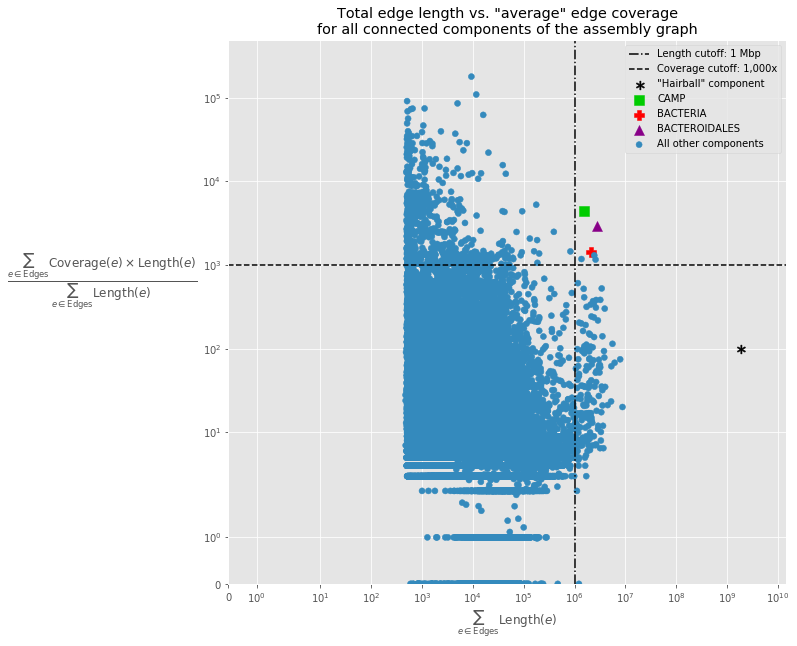

In [5]:
%run "GraphCovLenSummary.ipynb"